In [1]:
# Install Ultralytics library
!pip install ultralytics

  Obtaining dependency information for ultralytics from https://files.pythonhosted.org/packages/07/2b/05cc310e575ca7d9792745d088850368abb657de2947078672d5b28e5c7c/ultralytics-8.3.68-py3-none-any.whl.metadata
  Obtaining dependency information for ultralytics-thop>=2.0.0 from https://files.pythonhosted.org/packages/a6/10/251f036b4c5d77249f9a119cc89dafe8745dc1ad1f1a5f06b6a3988ca454/ultralytics_thop-2.0.14-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 913.6/913.6 kB 22.3 MB/s eta 0:00:00


In [2]:
# To solve problem with error "Wrong Attribute"
# !pip install ray== 2.0.0

In [3]:
# Disable warnings in the notebook to maintain clean output cells
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import cv2
import yaml
from PIL import Image
from collections import deque
from ultralytics import YOLO
from IPython.display import Video

# Work with errors
# from ray.train import get_context

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
# Configure the visual appearance of Seaborn plots
sns.set(rc={'axes.facecolor': '#ffe4de'}, style='darkgrid')

<img src="https://github.com/FarzadNekouee/YOLOv8_Pothole_Segmentation_Road_Damage_Assessment/blob/master/images/YOLOv8_segmentation_models.png?raw=true" width="2400">

In [5]:
# Load the pre-trained YOLOv8 nano segmentation model
model = YOLO('yolov8n-seg.pt') 

100%|██████████| 6.74M/6.74M [00:00<00:00, 137MB/s]


In [6]:
# Define the dataset_path
dataset_path = '/kaggle/input/pothole-image-segmentation-dataset/Pothole_Segmentation_YOLOv8'

# Set the path to the YAML file
yaml_file_path = os.path.join(dataset_path, 'data.yaml')

# Load and print the contents of the YAML file
with open(yaml_file_path, 'r') as file:
    yaml_content = yaml.load(file, Loader=yaml.FullLoader)
    print(yaml.dump(yaml_content, default_flow_style=False))

names:
- Pothole
nc: 1
roboflow:
  license: CC BY 4.0
  project: pothole_segmentation_yolov8
  url: https://universe.roboflow.com/farzad/pothole_segmentation_yolov8/dataset/1
  version: 1
  workspace: farzad
train: ../train/images
val: ../valid/images



In [7]:
# Set paths for training and validation image sets
train_images_path = os.path.join(dataset_path, 'train', 'images')
valid_images_path = os.path.join(dataset_path, 'valid', 'images')

# Initialize counters for the number of images
num_train_images = 0
num_valid_images = 0

# Initialize sets to hold the unique sizes of images
train_image_sizes = set()
valid_image_sizes = set()

# Check train images sizes and count
for filename in os.listdir(train_images_path):
    if filename.endswith('.jpg'):  
        num_train_images += 1
        image_path = os.path.join(train_images_path, filename)
        with Image.open(image_path) as img:
            train_image_sizes.add(img.size)

# Check validation images sizes and count
for filename in os.listdir(valid_images_path):
    if filename.endswith('.jpg'): 
        num_valid_images += 1
        image_path = os.path.join(valid_images_path, filename)
        with Image.open(image_path) as img:
            valid_image_sizes.add(img.size)

# Print the results
print(f"Number of training images: {num_train_images}")
print(f"Number of validation images: {num_valid_images}")

# Check if all images in training set have the same size
if len(train_image_sizes) == 1:
    print(f"All training images have the same size: {train_image_sizes.pop()}")
else:
    print("Training images have varying sizes.")

# Check if all images in validation set have the same size
if len(valid_image_sizes) == 1:
    print(f"All validation images have the same size: {valid_image_sizes.pop()}")
else:
    print("Validation images have varying sizes.")

Number of training images: 720
Number of validation images: 60
All training images have the same size: (640, 640)
All validation images have the same size: (640, 640)


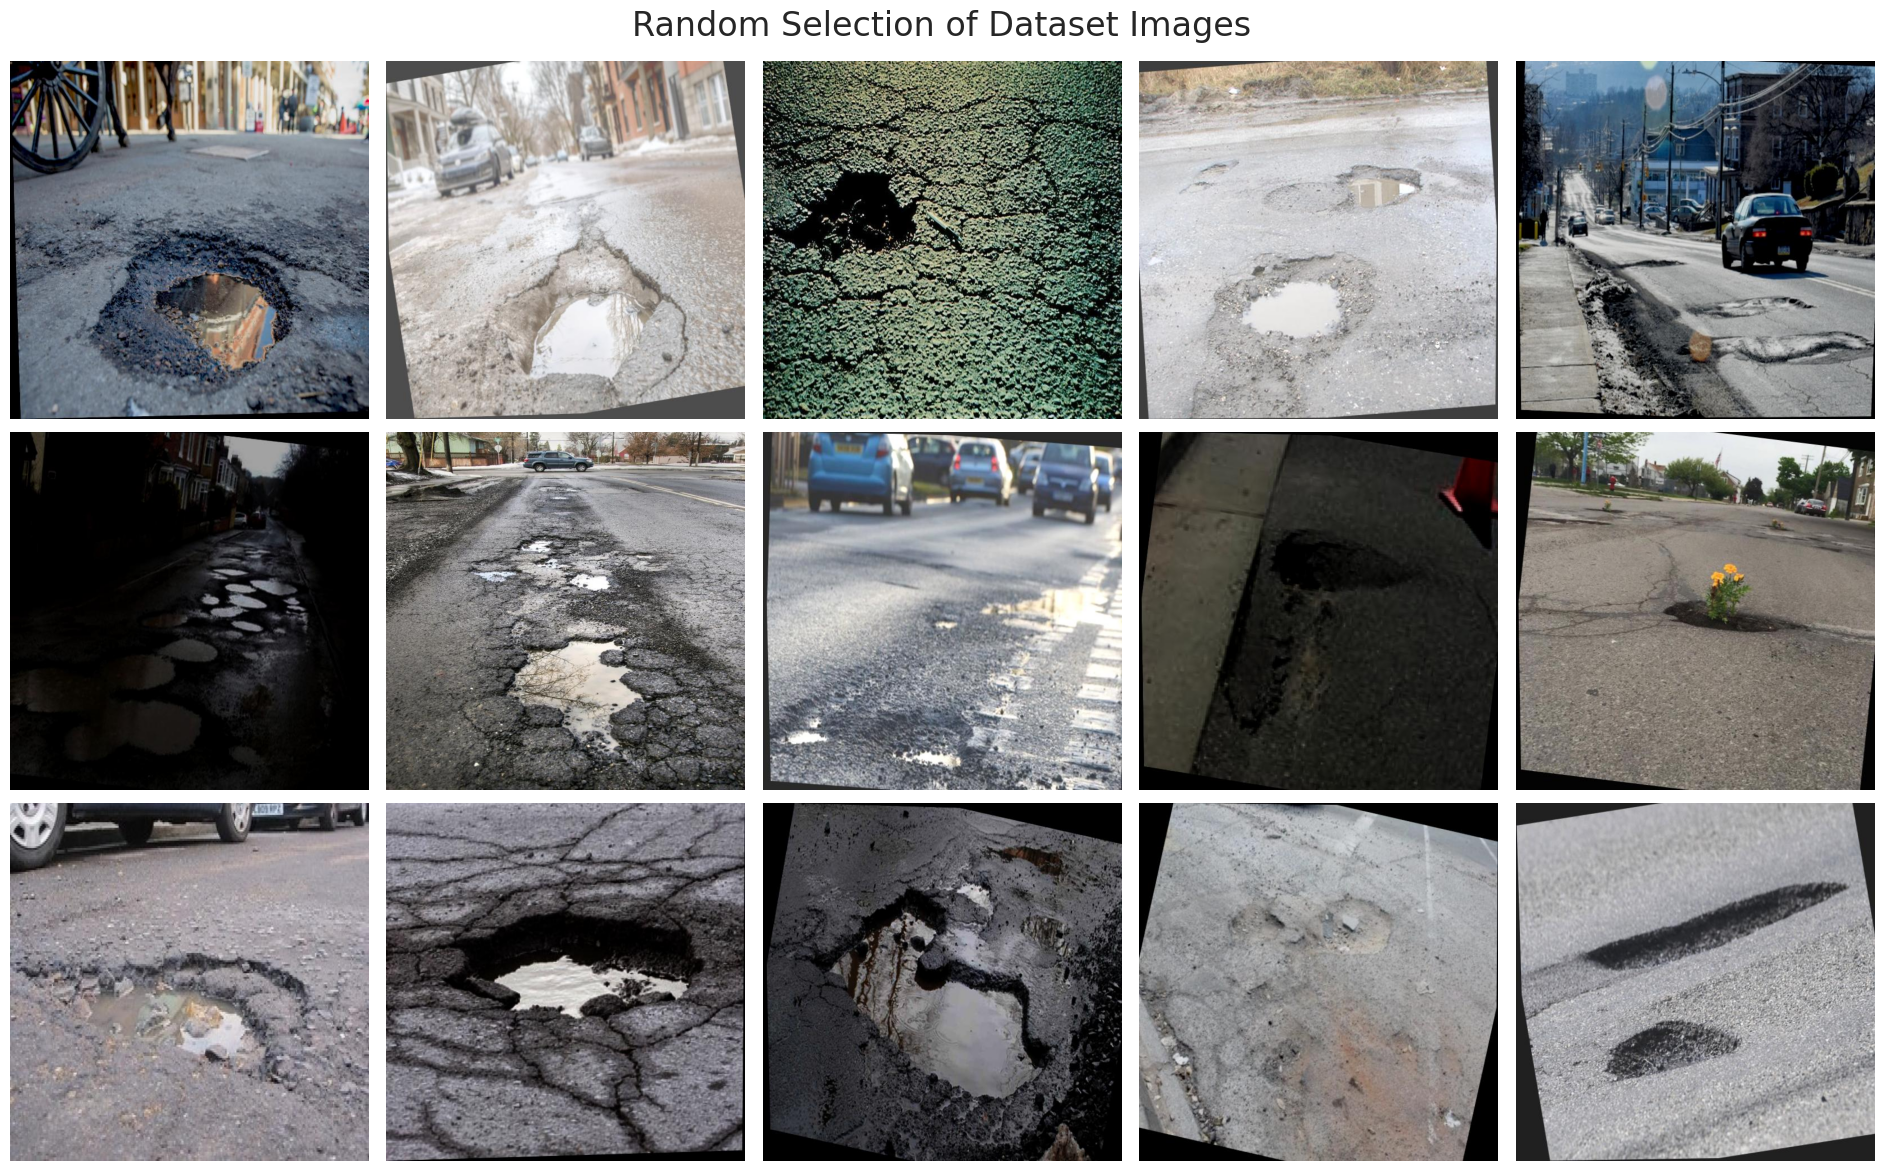

In [8]:
# Set the seed for the random number generator
random.seed(0)

# Create a list of image files
image_files = [f for f in os.listdir(train_images_path) if f.endswith('.jpg')]

# Randomly select 15 images
random_images = random.sample(image_files, 15)

# Create a new figure
plt.figure(figsize=(19, 12))

# Loop through each image and display it in a 3x5 grid
for i, image_file in enumerate(random_images):
    image_path = os.path.join(train_images_path, image_file)
    image = Image.open(image_path)
    plt.subplot(3, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')

# Add a suptitle
plt.suptitle('Random Selection of Dataset Images', fontsize=24)

# Show the plot
plt.tight_layout()
plt.show()

# Deleting unnecessary variable to free up memory
del image_files

In [9]:
# Train the model on our custom dataset
results = model.train(
    data=yaml_file_path,     # Path to the dataset configuration file
    epochs=150,              # Number of epochs to train for
    imgsz=640,               # Size of input images as integer
    patience=15,             # Epochs to wait for no observable improvement for early stopping of training
    batch=16,                # Number of images per batch
    optimizer='auto',        # Optimizer to use, choices=[SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto]
    lr0=0.0001,              # Initial learning rate 
    lrf=0.01,                # Final learning rate (lr0 * lrf)
    dropout=0.25,            # Use dropout regularization
    device=0,                # Device to run on, i.e. cuda device=0 
    seed=42                  # Random seed for reproducibility
)

Ultralytics 8.3.68 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=/kaggle/input/pothole-image-segmentation-dataset/Pothole_Segmentation_YOLOv8/data.yaml, epochs=150, time=None, patience=15, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.25, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_con

100%|██████████| 755k/755k [00:00<00:00, 22.6MB/s]
2025-01-27 11:33:17,865	INFO util.py:129 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-01-27 11:33:18,417	INFO util.py:129 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 99.4MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/input/pothole-image-segmentation-dataset/Pothole_Segmentation_YOLOv8/train/labels... 720 images, 0 backgrounds, 0 corrupt: 100%|██████████| 720/720 [00:01<00:00, 542.83it/s]

train: WARNING ⚠️ Cache directory /kaggle/input/pothole-image-segmentation-dataset/Pothole_Segmentation_YOLOv8/train is not writeable, cache not saved.


albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'


val: Scanning /kaggle/input/pothole-image-segmentation-dataset/Pothole_Segmentation_YOLOv8/valid/labels... 60 images, 0 backgrounds, 0 corrupt: 100%|██████████| 60/60 [00:00<00:00, 319.13it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/pothole-image-segmentation-dataset/Pothole_Segmentation_YOLOv8/valid is not writeable, cache not saved.


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/150      3.21G      1.494      3.006      2.393      1.438         67        640: 100%|██████████| 45/45 [00:18<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]

                   all         60        201      0.753     0.0758      0.263      0.118      0.852     0.0857      0.286      0.123


AttributeError: module 'ray.train._internal.session' has no attribute '_get_session'

In [ ]:
# Define the path to the directory
post_training_files_path = '/kaggle/working/runs/segment/train'

# List the files in the directory
!ls {post_training_files_path}

In [ ]:
# Create the full file path by joining the directory path with the filename
results_file_path = os.path.join(post_training_files_path, 'results.png')

# Read the image using cv2
image = cv2.imread(results_file_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  

# Display the image using matplotlib
plt.figure(figsize=(20, 8))
plt.imshow(image)
plt.title('Training and Validation Loss Trends', fontsize=24)
plt.axis('off') 
plt.show()

In [ ]:
# Define a function to plot learning curves for loss values
def plot_learning_curve(df, train_loss_col, val_loss_col, title, ylim_range=[0,2]):
    plt.figure(figsize=(12, 4))
    sns.lineplot(data=df, x='epoch', y=train_loss_col, label='Train Loss', color='blue', linestyle='-', linewidth=2)
    sns.lineplot(data=df, x='epoch', y=val_loss_col, label='Validation Loss', color='#ed2f00', linestyle='--', linewidth=2)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(ylim_range)
    plt.legend()
    plt.show()

In [ ]:
# Create the full file path for 'results.csv' using the directory path and file name
results_csv_path = os.path.join(post_training_files_path, 'results.csv')

# Load the CSV file from the constructed path into a pandas DataFrame
df = pd.read_csv(results_csv_path)

# Remove any leading whitespace from the column names
df.columns = df.columns.str.strip()

# Plot the learning curves for each loss
plot_learning_curve(df, 'train/box_loss', 'val/box_loss', 'Bounding Box Loss Learning Curve')
plot_learning_curve(df, 'train/cls_loss', 'val/cls_loss', 'Classification Loss Learning Curve')
plot_learning_curve(df, 'train/dfl_loss', 'val/dfl_loss', 'Distribution Focal Loss Learning Curve')
plot_learning_curve(df, 'train/seg_loss', 'val/seg_loss', 'Segmentation Loss Learning Curve', ylim_range=[0,5])

In [ ]:
# Define the filenames for 'Box' and 'Mask' metrics along with their titles
box_files_titles = {
    'BoxP_curve.png': 'Bounding Box Precision-Confidence Curve',
    'BoxR_curve.png': 'Bounding Box Recall-Confidence Curve',
    'BoxF1_curve.png': 'Bounding Box F1-Confidence Curve'
}
mask_files_titles = {
    'MaskP_curve.png': 'Mask Precision-Confidence Curve',
    'MaskR_curve.png': 'Mask Recall-Confidence Curve',
    'MaskF1_curve.png': 'Mask F1-Confidence Curve'
}

# Create a 3x2 subplot
fig, axs = plt.subplots(3, 2, figsize=(20, 20))

# Function to read and convert image for plotting
def read_and_convert_image(file_path):
    # Read the image using cv2
    image = cv2.imread(file_path)
    # Convert from BGR to RGB
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot 'Box' images in the first column with meaningful titles
for i, (filename, title) in enumerate(box_files_titles.items()):
    img_path = os.path.join(post_training_files_path, filename)
    img = read_and_convert_image(img_path)
    axs[i, 0].imshow(img)
    axs[i, 0].set_title(title, fontsize=20)
    axs[i, 0].axis('off') 

# Plot 'Mask' images in the second column with meaningful titles
for i, (filename, title) in enumerate(mask_files_titles.items()):
    img_path = os.path.join(post_training_files_path, filename)
    img = read_and_convert_image(img_path)
    axs[i, 1].imshow(img)
    axs[i, 1].set_title(title, fontsize=20)
    axs[i, 1].axis('off')  

plt.tight_layout()
plt.show()

In [ ]:
# Define the filenames for 'Box' and 'Mask' metrics along with their titles
pr_files_titles = {
    'BoxPR_curve.png': 'Bounding Box Precision-Recall Curve',
    'MaskPR_curve.png': 'Mask Precision-Recall Curve'
}

# Create a 1x2 subplot
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Plot 'Box' and 'Mask' images in the subplot with meaningful titles
for i, (filename, title) in enumerate(pr_files_titles.items()):
    img_path = os.path.join(post_training_files_path, filename)
    img = read_and_convert_image(img_path)
    axs[i].imshow(img)
    axs[i].set_title(title, fontsize=20)
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Construct the path to the confusion matrix images
confusion_matrix_path = os.path.join(post_training_files_path, 'confusion_matrix.png')
confusion_matrix_normalized_path = os.path.join(post_training_files_path, 'confusion_matrix_normalized.png')

# Create a 1x2 subplot
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Read and convert both images
cm_img = read_and_convert_image(confusion_matrix_path)
cm_norm_img = read_and_convert_image(confusion_matrix_normalized_path)

# Display the images
axs[0].imshow(cm_img)
axs[0].set_title('Confusion Matrix', fontsize=24)
axs[0].axis('off') 

axs[1].imshow(cm_norm_img)
axs[1].set_title('Normalized Confusion Matrix', fontsize=24)
axs[1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Construct the path to the best model weights file using os.path.join
best_model_path = os.path.join(post_training_files_path, 'weights/best.pt')

# Load the best model weights into the YOLO model
best_model = YOLO(best_model_path)

# Validate the best model using the validation set with default parameters
metrics = best_model.val(split='val')

In [ ]:
# Convert the dictionary to a pandas DataFrame and use the keys as the index
metrics_df = pd.DataFrame.from_dict(metrics.results_dict, orient='index', columns=['Metric Value'])

# Display the DataFrame
metrics_df.round(3)

In [ ]:
# Define the path to the validation images
valid_images_path = os.path.join(dataset_path, 'valid', 'images')

# List all jpg images in the directory
image_files = [file for file in os.listdir(valid_images_path) if file.endswith('.jpg')]

# Select 9 images at equal intervals
num_images = len(image_files)
selected_images = [image_files[i] for i in range(0, num_images, num_images // 9)]

# Initialize the subplot
fig, axes = plt.subplots(3, 3, figsize=(20, 21))
fig.suptitle('Validation Set Inferences', fontsize=24)

# Perform inference on each selected image and display it
for i, ax in enumerate(axes.flatten()):
    image_path = os.path.join(valid_images_path, selected_images[i])
    results = best_model.predict(source=image_path, imgsz=640)
    annotated_image = results[0].plot()
    annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
    ax.imshow(annotated_image_rgb)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Define the path to the sample video in the dataset
dataset_video_path = '/kaggle/input/pothole-image-segmentation-dataset/Pothole_Segmentation_YOLOv8/sample_video.mp4'

# Define the destination path in the working directory
video_path = '/kaggle/working/sample_video.mp4'

# Copy the video file from its original location in the dataset to the current working directory in Kaggle
shutil.copyfile(dataset_video_path, video_path)

# Initiate vehicle detection on the sample video using the best performing model and save the output
best_model.predict(source=video_path, save=True)

In [ ]:
# Convert the .avi video generated by the YOLOv8 prediction to .mp4 format for compatibility with notebook display
!ffmpeg -y -loglevel panic -i /kaggle/working/runs/segment/predict/sample_video.avi processed_sample_video.mp4

# Embed and display the processed sample video within the notebook
Video("processed_sample_video.mp4", embed=True, width=960)

In [ ]:
# Export the model
best_model.export(format='onnx')

In [ ]:
# Define the path to the validation images
valid_images_path = os.path.join(dataset_path, 'valid', 'images')

# List all jpg images in the directory
image_files = [file for file in os.listdir(valid_images_path) if file.endswith('.jpg')]

# Select a sample image
selected_image = image_files[45]

# Perform inference on the selected image
image_path = os.path.join(valid_images_path, selected_image)
results = best_model.predict(source=image_path, imgsz=640, conf=0.5)
annotated_image = results[0].plot()
annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

# Determine the number of subplots needed (1 original + number of masks)
num_subplots = 1 + (len(results[0].masks.data) if results[0].masks is not None else 0)

# Initialize the subplot with 1 row and n columns
fig, axes = plt.subplots(1, num_subplots, figsize=(15, 5))

# Display the original annotated image
axes[0].imshow(annotated_image_rgb)
axes[0].set_title('Original Image')
axes[0].axis('off')

# If multiple masks, iterate and display each mask
if results[0].masks is not None:
    masks = results[0].masks.data.cpu().numpy()
    for i, mask in enumerate(masks):
        # Threshold the mask to make sure it's binary
        # Any value greater than 0 is set to 255, else it remains 0
        binary_mask = (mask > 0).astype(np.uint8) * 255
        axes[i+1].imshow(binary_mask, cmap='gray')
        axes[i+1].set_title(f'Segmented Mask {i+1}')
        axes[i+1].axis('off')

# Adjust layout and display the subplot
plt.tight_layout()
plt.show()

In [ ]:
# Initialize variables to hold total area and individual areas
total_area = 0
area_list = []

# Set up the subplot for displaying masks
fig, axes = plt.subplots(1, len(masks), figsize=(12, 8))

# Perform operations if masks are available
if results[0].masks is not None:
    masks = results[0].masks.data.cpu().numpy()   # Retrieve masks as numpy arrays
    image_area = masks.shape[1] * masks.shape[2]  # Calculate total number of pixels in the image
    for i, mask in enumerate(masks):
        binary_mask = (mask > 0).astype(np.uint8) * 255  # Convert mask to binary
        color_mask = cv2.cvtColor(binary_mask, cv2.COLOR_GRAY2BGR)  # Convert binary mask to color
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)  # Find contours in the binary mask
        contour = contours[0]  # Retrieve the first contour
        area = cv2.contourArea(contour)  # Calculate the area of the pothole
        area_list.append(area)  # Append area to the list
        cv2.drawContours(color_mask, [contour], -1, (0, 255, 0), 3)  # Draw the contour on the mask

        # Display the mask with the green contour
        axes[i].imshow(color_mask)
        axes[i].set_title(f'Pothole {i+1}')
        axes[i].axis('off')

# Display all masks
plt.tight_layout()
plt.show()

# Calculate and print areas after displaying the images
for i, area in enumerate(area_list):
    print(f"Area of Pothole {i+1}: {area} pixels")  
    total_area += area  # Sum the areas for total

# Calculate and print the total damaged area and percentage of road damaged by potholes
print("-"*50)
print(f"Total Damaged Area by Potholes: {total_area} pixels")
print(f"Total Pixels in Image: {image_area} pixels")
print(f"Percentage of Road Damaged: {(total_area / image_area) * 100:.2f}%")

In [ ]:
# Define the video path
video_path = '/kaggle/working/sample_video.mp4'

# Define font, scale, colors, and position for the annotation
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1
text_position = (40, 80)
font_color = (255, 255, 255)    # White color for text
background_color = (0, 0, 255)  # Red background for text

# Initialize a deque with fixed length for averaging the last 10 percentage damages
damage_deque = deque(maxlen=10)

# Open the video
cap = cv2.VideoCapture(video_path)

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('road_damage_assessment.avi', fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

# Read until video is completed
while cap.isOpened():
     # Capture frame-by-frame
    ret, frame = cap.read()
    if ret:
        # Perform inference on the frame
        results = best_model.predict(source=frame, imgsz=640, conf=0.25)
        processed_frame = results[0].plot(boxes=False)
        
        # Initializes percentage_damage to 0
        percentage_damage = 0 
        
        # If masks are available, calculate total damage area and percentage
        if results[0].masks is not None:
            total_area = 0
            masks = results[0].masks.data.cpu().numpy()
            image_area = frame.shape[0] * frame.shape[1]  # total number of pixels in the image
            for mask in masks:
                binary_mask = (mask > 0).astype(np.uint8) * 255
                contour, _ = cv2.findContours(binary_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                total_area += cv2.contourArea(contour[0])
            
            percentage_damage = (total_area / image_area) * 100

        # Calculate and update the percentage damage
        damage_deque.append(percentage_damage)
        smoothed_percentage_damage = sum(damage_deque) / len(damage_deque)
            
        # Draw a thick line for text background
        cv2.line(processed_frame, (text_position[0], text_position[1] - 10),
                 (text_position[0] + 350, text_position[1] - 10), background_color, 40)
        
        # Annotate the frame with the percentage of damage
        cv2.putText(processed_frame, f'Road Damage: {smoothed_percentage_damage:.2f}%', text_position, font, font_scale, font_color, 2, cv2.LINE_AA)         
    
        # Write the processed frame to the output video
        out.write(processed_frame)
        
        # Uncomment the following 3 lines if running this code on a local machine to view the real-time processing results
        # cv2.imshow('Road Damage Assessment', processed_frame) # Display the processed frame
        # if cv2.waitKey(1) & 0xFF == ord('q'): # Press Q on keyboard to exit the loop
        #     break 
    else:
        break

# Release the video capture and video write objects
cap.release()
out.release()

# Close all the frames
# cv2.destroyAllWindows()

In [ ]:
# Convert the .avi video generated by our traffic density estimation app to .mp4 format for compatibility with notebook display
!ffmpeg -y -loglevel panic -i /kaggle/working/road_damage_assessment.avi road_damage_assessment.mp4

# Embed and display the processed sample video within the notebook
Video("road_damage_assessment.mp4", embed=True, width=960)